In [1]:
# --- IMPORTS ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# --- CONFIG ---
train_files = [
    "parsed_emg/subject_1/trial_12(left).csv",
    "parsed_emg/subject_1/trial_10(left).csv",
    "parsed_emg/subject_1/trial_8(left).csv",
    "parsed_emg/subject_1/trial_6(left).csv",
    "parsed_emg/subject_1/trial_4(left).csv"
]
test_file = "parsed_emg/subject_1/trial_2(left).csv"
label_col = 5
batch_size = 64
learning_rate = 1e-3
epochs = 25 
num_classes = 3

# --- LOAD CSV ---
def load_csv_with_time(path):
    df = pd.read_csv(path, skiprows=1)
    time = df.iloc[:, 0].values.reshape(-1, 1)  # absolute time
    emg = df.iloc[:, 1:5].values.astype("float32")
    X = np.concatenate([time, emg], axis=1)  # shape: (N, 5)
    y = df.iloc[:, label_col].values.astype("int32")
    return X, y


Class weights: {0: 0.5, 1: 3.3, 2: 4.0}
Epoch 1/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - accuracy: 0.7308 - loss: 2.3161 - val_accuracy: 0.7496 - val_loss: 1.0006
Epoch 2/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.7825 - loss: 1.7735 - val_accuracy: 0.7696 - val_loss: 0.8184
Epoch 3/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 0.7884 - loss: 1.6812 - val_accuracy: 0.7875 - val_loss: 0.7431
Epoch 4/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - accuracy: 0.7929 - loss: 1.6372 - val_accuracy: 0.7700 - val_loss: 0.7516
Epoch 5/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.7961 - loss: 1.5989 - val_accuracy: 0.7796 - val_loss: 0.7600
Epoch 6/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.7986 - loss: 1.5727 - val_accuracy: 0.7855 - val_loss: 0.7629
Epoch 7/25
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.7999 - loss: 1.5568 - val_accuracy: 0.7873 - val_loss: 0.6819
Epoch 8/25
33636/33636 ━━━━━

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

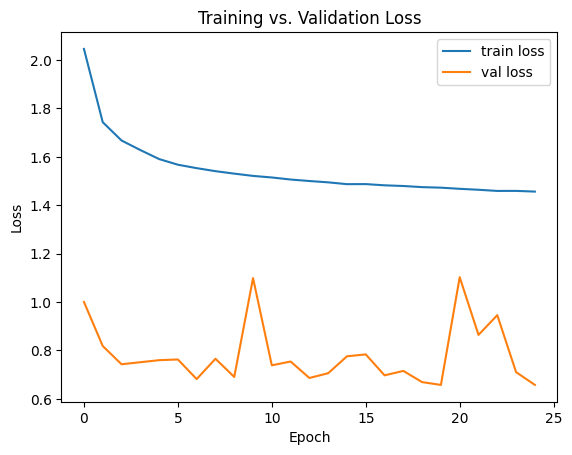

In [ ]:
# --- LOAD DATA ---
raw_X_all, raw_y_all = [], []
for f in train_files:
    X, y = load_csv_with_time(f)
    raw_X_all.append(X)
    raw_y_all.append(y)
raw_X_all = np.concatenate(raw_X_all)
raw_y_all = np.concatenate(raw_y_all)

# Normalize (including time)
scaler = MinMaxScaler(feature_range=(0, 1))
raw_X_all = scaler.fit_transform(raw_X_all)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    raw_X_all, raw_y_all, test_size=0.1, random_state=42, stratify=raw_y_all
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Test set
X_test_raw, y_test = load_csv_with_time(test_file)
X_test = scaler.transform(X_test_raw)


class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)


class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {
    0: total_samples / (len(class_counts) * class_counts[0]),
    1: total_samples / (len(class_counts) * class_counts[1]),
    2: total_samples / (len(class_counts) * class_counts[2])
}
print(class_weights)

# --- MODEL ---
model = tf.keras.Sequential([
    layers.Input(shape=(5,)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_entropy',
    metrics=['accuracy']
)

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# --- EVALUATE ---
# Original model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nOriginal Model - Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


# --- PLOTS ---
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.save('loss.png')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.save('acc.png')
plt.show()

# Confusion matrix - Original Model
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
plt.figure()
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Original Model - Confusion Matrix')
plt.save('cmax.png')
plt.show()


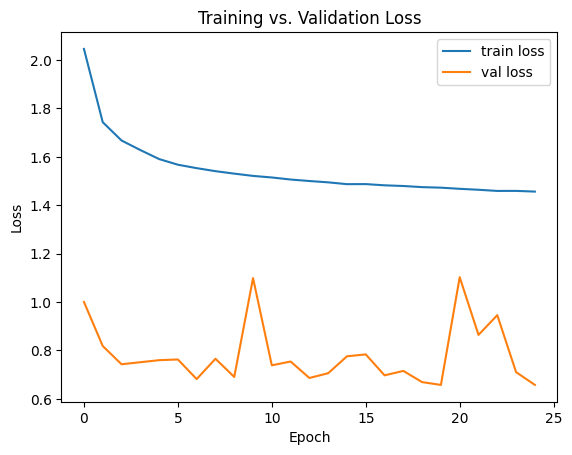

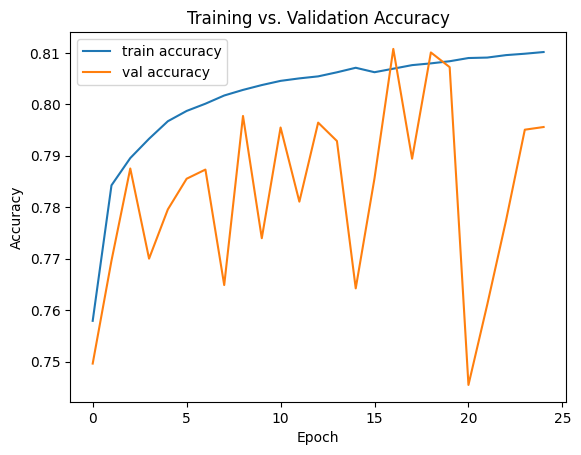

4408/4408 ━━━━━━━━━━━━━━━━━━━━ 3s 552us/step


<Figure size 640x480 with 0 Axes>

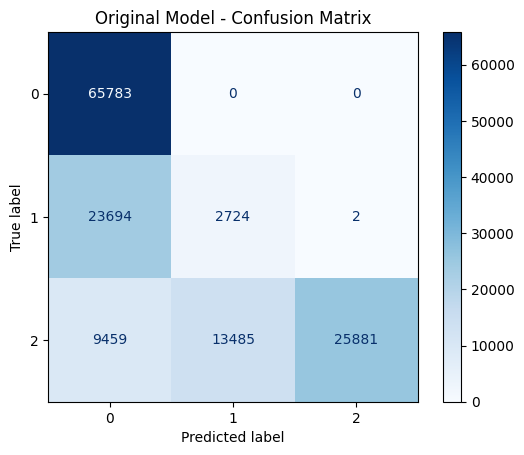

In [4]:
# --- PLOTS ---
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.savefig('loss.png')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.savefig('acc.png')
plt.show()

# Confusion matrix - Original Model
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
plt.figure()
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Original Model - Confusion Matrix')
plt.savefig('cmax.png')
plt.show()
